In [ ]:
#  import libraries

import sqlite3
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from category_encoders import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.validation import check_is_fitted

* Prepare Data

Import

In [ ]:
  def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")
    
    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Add high-cardinality / redundant column
    drop_cols.append("building_id")

    # Create binary target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    # Drop old target
    drop_cols.append("damage_grade")

    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")

    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    return df

In [ ]:
df = wrangle("/home/jovyan/nepal.sqlite")
df.head()

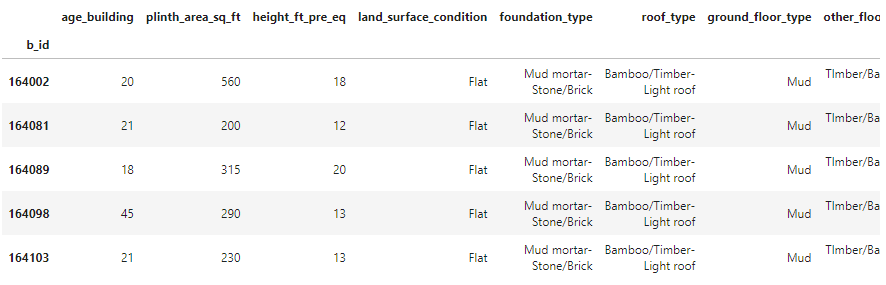

Split

In [ ]:
target = "severe_damage"
X = df.drop(columns=target) 
y = df[target]

Randomized Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size= 0.2, random_state= 42
)

Dividing training data (X_train and y_train) into training and validation sets using a randomized train-test split. 
Validation data should be 20% of the remaining data.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size= 0.2, random_state= 42
)

* Build Model

Baseline

Calculating the baseline accuracy score for the model.

In [ ]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

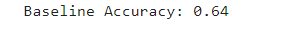

Creating a pipeline named model that contains a OrdinalEncoder transformer and a DecisionTreeClassifier predictor. 

Then fitting the model to the training data.

In [ ]:
# Build Model
model = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=6,random_state=42)
)
# Fit model to training data
model.fit(X_train, y_train)

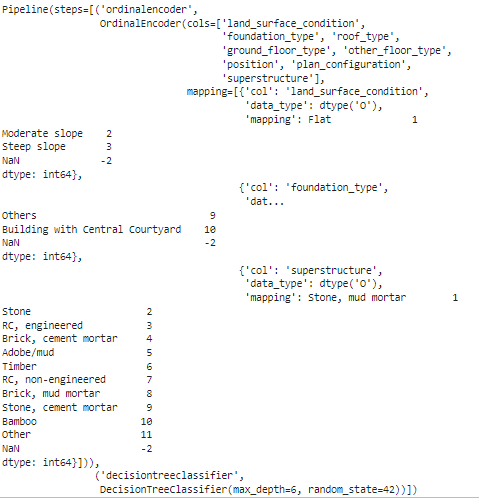

* Evaluate model

Calculating the training and validation accuracy scores for the models.


In [ ]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_val = model.score(X_val, y_val)

print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

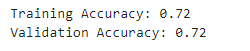

Tree depth 

Using the get_depth method on the DecisionTreeClassifier in the model to see how deep our tree grew during training.


In [ ]:
tree_depth = model.named_steps["decisiontreeclassifier"].get_depth()
print("Tree Depth:", tree_depth)

Hyperparameter Tunning 1

Creating a range of possible values for max_depth hyperparameter of the model's DecisionTreeClassifier.

depth_hyperparams should range from 1 to 50 by steps of 2.



In [ ]:
depth_hyperparams = range(1,50,2)

Hyperparameter Tunning 2

Completing the code below so that it trains a model for every max_depth in depth_hyperparams. Every time a new model is trained, the code should also calculating the training and validation accuracy scores and appending them to the training_acc and validation_acc lists, respectively.

In [ ]:
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=d, random_state=42)
    )
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

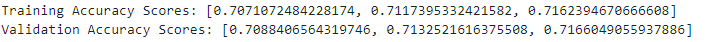

Validation Curve

Creating a visualization with two lines. The first line should plot the training_acc values as a function of depth_hyperparams, and the second should plot validation_acc as a function of depth_hyperparams. 

In [ ]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, label="Training")
plt.plot(depth_hyperparams, validation_acc, label="Validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

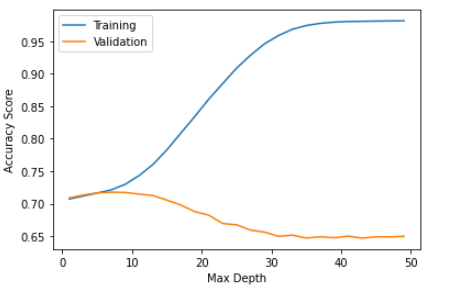

* Evaluate model

Based on visualization, we can choose the max_depth value that leads to the best validation accuracy score. Then retrain our original model with that max_depth value. Lastly, by checking how our tuned model performs on our test set by calculating the test accuracy score . Now we are able to resolve the overfitting problem with this new max_depth

In [ ]:
test_acc = model.score(X_test, y_test)
print("Test Accuracy:", round(test_acc, 2))

Plot tree model

Using the plot_tree function from scikit-learn to visualize the decision logic of our model.

In [ ]:
# Create larger figure
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree=model.named_steps["decisiontreeclassifier"],
    feature_names=X_train.columns,
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

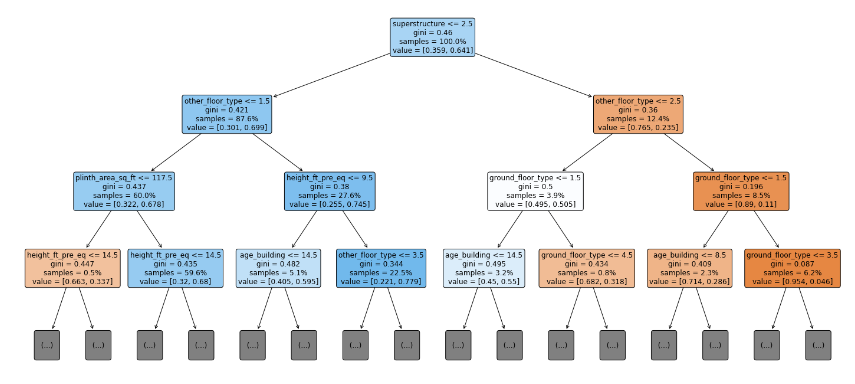

Extract feature importance

Assigning the feature names and importances of our model to the variables below. For the features, we can get them from the column names in our training set. For the importances, we access the feature_importances_ attribute of our model's DecisionTreeClassifier

In [ ]:
features = X_train.columns
importances = model.named_steps["decisiontreeclassifier"].feature_importances_

print("Features:", features[:3])
print("Importances:", importances[:3])

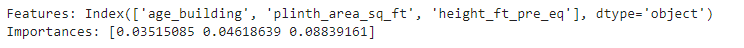

 Creating a pandas Series named feat_imp, where the index is features and the values are our importances. The Series should be sorted from smallest to largest importance.

In [ ]:
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.head()

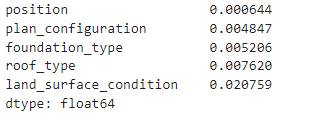

Gini impurity bar chart

Creating a horizontal bar chart with all the features in feat_imp. 

In [ ]:
# Create horizontal bar chart
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature");

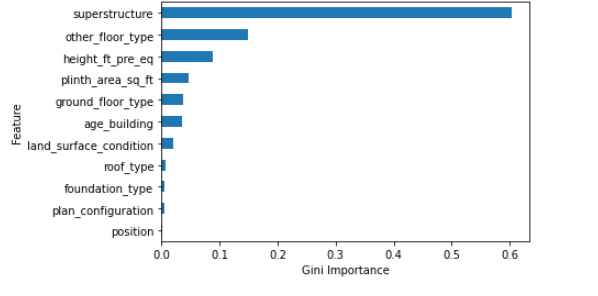

Gini importance value for Superstructure is 0.6. It means over the split our tree does from the root to the leaves, the Superstructure feature is responsible for about 0.6 percent of that dccreasing impurity in the nodes. Likewise, height_ft_pre_eq is responisble of about 0.1 reduction of impurity over the course trees.